In [1]:
! pip install ..

Processing /workspaces/Zero_Day_Phishing_Project
  Preparing metadata (setup.py) ... done
  Created wheel for zdpd_model: filename=zdpd_model-0.1.1-py3-none-any.whl size=15910 sha256=df4c5dc8f88d7199658a01ec1a75cadeecfd56af53db7eef5bb9e914a01acd07
  Stored in directory: /tmp/pip-ephem-wheel-cache-23bb2gm_/wheels/3b/b1/38/24de9b98f684166fed6c50c4b23b0a16322f1ccd4b02922439
Successfully built zdpd_model
  Attempting uninstall: zdpd_model
    Found existing installation: zdpd_model 0.1.1
    Uninstalling zdpd_model-0.1.1:
      Successfully uninstalled zdpd_model-0.1.1


## Data Preprocessing

In [2]:
import pandas as pd
from pathlib import Path
from typing import Optional, Tuple
from sklearn.model_selection import train_test_split

from zdpd_model.preprocessing.main import MainPreprocessor

Extract raw data from each source

In [3]:
DATA_FOLDER = Path().cwd().parent / "data"
sources = ["Enron", "Nazario", "Nigerian_Fraud", "SpamAssasin"]
columns_of_interest = ["subject", "body", "label"]
merged_data = pd.DataFrame()

for source in sources:
    raw_data = pd.read_csv(DATA_FOLDER / f"{source}.csv")[columns_of_interest]
    raw_data["source"] = source
    merged_data = pd.concat([merged_data, raw_data], axis=0, ignore_index=True)

Count by classification

In [4]:
merged_data["label"].value_counts()

1    20570
0    19842
Name: label, dtype: int64

Preprocessing pipeline

In [ ]:
data_prepr = MainPreprocessor.apply(merged_data)
data_prepr.to_csv(DATA_FOLDER / f"preprocessed_data.csv", index=False)

Running EmptySubjectToStr ...
Running EmptyBodyToStr ...
Running RemoveUnwantedCharacters ...
Running RemoveLeadingGreaterThan ...
Running RemoveMultiSpacing ...
Running RemoveMultipleNL ...
Running RemoveLeadingTrailingNL ...
Running ReplaceAttachedFilePatternEnron ...
Running RemoveCopiedInformationEnron ...


/opt/conda/envs/py_env/lib/python3.10/site-packages/zdpd_model/preprocessing/re_fw_removals.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enron_df["body"] = enron_df["body"].apply(cls._remove_all)
/opt/conda/envs/py_env/lib/python3.10/site-packages/zdpd_model/preprocessing/text_removals.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nf_df["body"] = nf_df["body"].apply(


Running RemoveHeadersNigerianFraud ...
Running RemoveDuplicateTextNazario ...


/opt/conda/envs/py_env/lib/python3.10/site-packages/zdpd_model/preprocessing/text_removals.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nazario_df["body"] = nazario_df["body"].apply(cls._cut_duplicate_text)


Running FixUnicodeErrors ...
Running RemoveEmptyBodyEmails ...


Read preprocessed data

In [ ]:
data_prepr = pd.read_csv(DATA_FOLDER / f"preprocessed_data.csv")

Classification count after preprocessing

In [5]:
data_prepr["label"].value_counts()

1    19419
0    19295
Name: label, dtype: int64

In [8]:
data_prepr.groupby(["source", "label"])["body"].count()

source          label
Enron           0        15216
                1        13972
Nazario         1         1561
Nigerian_Fraud  1         2186
SpamAssasin     0         4079
                1         1700
Name: body, dtype: int64

Duplicates

In [10]:
data_prepr["body"].value_counts().head(5)

fyi            108
we agree        48
the             36
fyi .           28
fyi , kim .     25
Name: body, dtype: int64

Train-Validation-Test Split

In [5]:
def split_70_15_15(
    data: pd.DataFrame,
    random_state: Optional[int] = 11235
) -> Tuple[pd.DataFrame]:
    """Split a dataset as 70-15-15."""
    train, temp = train_test_split(
        data, 
        test_size=0.3, 
        random_state=random_state
    )
    validation = temp.iloc[:int(len(temp) / 2), :]
    test = temp.iloc[int(len(temp) / 2):, :]
    
    return (train, validation, test)

In [6]:
# Separate phishing and non-phishing
non_phishing = data_prepr[data_prepr['label'] == 0]  # Normal emails
phishing = data_prepr[data_prepr['label'] == 1]      # Phishing emails

# Split data sets
np_train, np_val, np_test = split_70_15_15(non_phishing, random_state=78)
_, p_val, p_test = split_70_15_15(phishing, random_state=43)

# Combine datasets
train_set = np_train
val_set = pd.concat([np_val, p_val], axis=0)
test_set = pd.concat([np_test, p_test], axis=0)

## Encoding

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

from zdpd_model.modeling import CLSEncoder, MeanPoolingEncoder

DATA_FOLDER = Path().cwd().parent / "data"
train_set = pd.read_csv(DATA_FOLDER / "train_data.csv", index_col=0)
validation_set = pd.read_csv(DATA_FOLDER / "validation_data.csv", index_col=0)
test_set = pd.read_csv(DATA_FOLDER / "test_data.csv", index_col=0)

In [5]:
def encode_data(data: pd.DataFrame, encoder_name: str, filename: str):
    encoders = {"cls": CLSEncoder, "mean_pooling": MeanPoolingEncoder}
    encoder = encoders[encoder_name]()
    encoded_data = pd.DataFrame()

    size = int((len(data) / 10) + 1)

    for i in range(10):
        start = i * size
        end = (i + 1) * size
        
        print("Running portion {} ({}-{})-{}-{} ...".format(
            i, start, end, str(pd.Timestamp.now())[11:19], encoder_name
        ))
        encoded_data = pd.concat([
            encoded_data,
            pd.DataFrame(data["body"].iloc[start: end].apply(
                lambda x: encoder.encode(x)
            ).tolist(), index=data.iloc[start: end].index)
        ], axis=0)
    
    encoded_data.to_csv(DATA_FOLDER / filename)
    return encoded_data

In [ ]:
train_enc_cls = encode_data(train_set, "cls", "train_data_enc_cls.csv")
train_enc_mp = encode_data(train_set, "mean_pooling", "train_data_enc_mp.csv")
val_enc_cls = encode_data(validation_set, "cls", "validation_data_enc_cls.csv")
val_enc_mp = encode_data(validation_set, "mean_pooling", "validation_data_enc_mp.csv")
test_enc_cls = encode_data(test_set, "cls", "test_data_enc_cls.csv")
test_enc_mp = encode_data(test_set, "mean_pooling", "test_data_enc_mp.csv")

Running portion 0 (0-1351)-17:10:19-cls ...


Token indices sequence length is longer than the specified maximum sequence length for this model (1125 > 512). Running this sequence through the model will result in indexing errors


Running portion 1 (1351-2702)-17:21:19-cls ...
Running portion 2 (2702-4053)-17:33:10-cls ...
Running portion 3 (4053-5404)-17:44:37-cls ...
Running portion 4 (5404-6755)-18:00:45-cls ...
Running portion 5 (6755-8106)-18:16:31-cls ...
Running portion 6 (8106-9457)-18:32:17-cls ...
Running portion 7 (9457-10808)-18:50:01-cls ...
Running portion 8 (10808-12159)-19:06:26-cls ...
Running portion 9 (12159-13510)-19:22:42-cls ...
Running portion 0 (0-1351)-19:37:24-mean_pooling ...


Token indices sequence length is longer than the specified maximum sequence length for this model (1123 > 512). Running this sequence through the model will result in indexing errors


Running portion 1 (1351-2702)-19:51:41-mean_pooling ...
Running portion 2 (2702-4053)-20:06:54-mean_pooling ...
Running portion 3 (4053-5404)-20:21:51-mean_pooling ...
Running portion 4 (5404-6755)-20:39:29-mean_pooling ...
Running portion 5 (6755-8106)-20:56:15-mean_pooling ...
Running portion 6 (8106-9457)-21:07:13-mean_pooling ...
Running portion 7 (9457-10808)-21:18:26-mean_pooling ...
Running portion 8 (10808-12159)-21:28:48-mean_pooling ...
Running portion 9 (12159-13510)-21:40:32-mean_pooling ...


In [14]:
train_enc_cls = pd.read_csv(DATA_FOLDER / "train_data_enc_cls.csv", index_col=0)
train_enc_mp = pd.read_csv(DATA_FOLDER / "train_data_enc_mp.csv", index_col=0)

Magnitude of vectors

In [19]:
norm_cls = pd.Series(np.linalg.norm(train_enc_cls.values, axis=1))
norm_cls.describe()

count    13506.000000
mean        14.433891
std          1.233283
min          8.593712
25%         14.271147
50%         14.730490
75%         15.086496
max         17.034134
dtype: float64

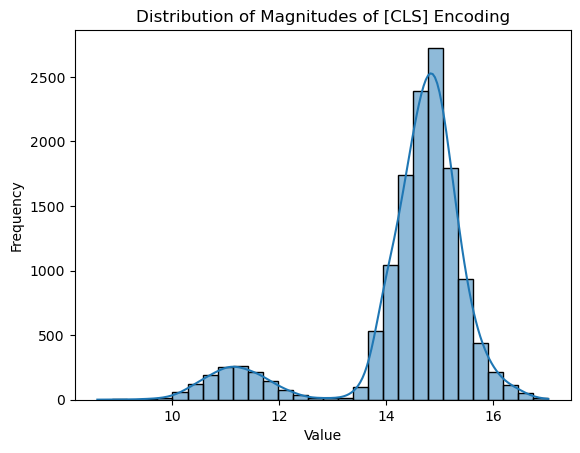

In [20]:
sns.histplot(norm_cls, kde=True, bins=30)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Distribution of Magnitudes of [CLS] Encoding")
plt.show()

In [17]:
norm_mp = pd.Series(np.linalg.norm(train_enc_mp.values, axis=1))
norm_mp.describe()

count    13506.000000
mean         9.375323
std          1.351433
min          7.490387
25%          8.369984
50%          8.886628
75%         10.043637
max         17.311864
dtype: float64

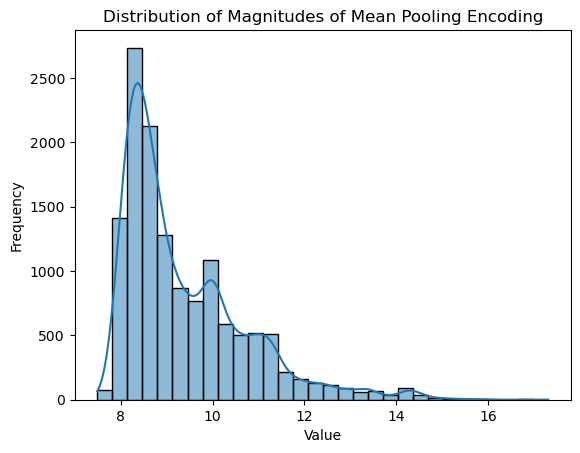

In [18]:
sns.histplot(norm_mp, kde=True, bins=30)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Distribution of Magnitudes of Mean Pooling Encoding")
plt.show()

In [15]:
# Euclidean distance between corresponding rows
df_distances = np.sqrt(((train_enc_cls - train_enc_mp) ** 2).sum(axis=1))
df_distances.describe()

count    13506.000000
mean        15.117350
std          1.888866
min          5.951281
25%         14.623064
50%         15.403480
75%         16.094885
max         24.079459
dtype: float64

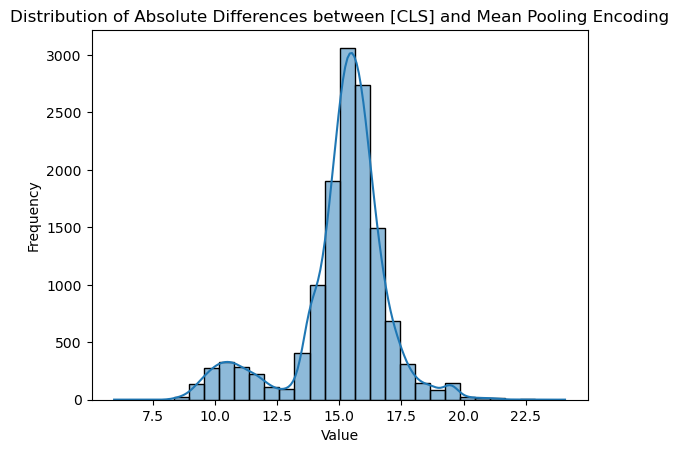

In [16]:
sns.histplot(df_distances, kde=True, bins=30)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Distribution of Absolute Differences between [CLS] and Mean Pooling Encoding")
plt.show()

## Training Reconstruction Models

In [2]:
import pandas as pd
from itertools import product
from pathlib import Path
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score
from typing import List, Tuple

from zdpd_model.modeling import (
    OCSVMReconstruction, PCAReconstruction, VAEReconstruction
)

DATA_FOLDER = Path().cwd().parent / "data"
X_train_cls = pd.read_csv(DATA_FOLDER / "train_data_enc_cls.csv", index_col=0)
X_train_mp = pd.read_csv(DATA_FOLDER / "train_data_enc_mp.csv", index_col=0)
X_val_cls = pd.read_csv(DATA_FOLDER / "validation_data_enc_cls.csv", index_col=0)
X_val_mp = pd.read_csv(DATA_FOLDER / "validation_data_enc_mp.csv", index_col=0)
y_val = pd.read_csv(DATA_FOLDER / "validation_data.csv", index_col=0)["label"]

/opt/conda/envs/py_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### PCA

In [18]:
n_components_list = [
    250, 300, 350, 400, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 750
]
re_quantiles = [0.8, 0.85, 0.9, 0.95, 0.99]
param_grid = list(product(n_components_list, re_quantiles))

def grid_search_pca(
    X_train: pd.DataFrame,
    X_val: pd.DataFrame,
    y_val: pd.Series,
    param_grid: List
) -> pd.DataFrame:

    results = []

    for n_components, q in param_grid:
        print("{}--Training with: n_components={}, quantile={} ...".format(
            str(pd.Timestamp.now(tz="America/Mexico_City"))[11:19], n_components, q
        ))
        model = PCAReconstruction(n_components=n_components, re_quantile=q)
        model.fit(X_train)
        y_pred = model.predict(X_val)
        
        metrics = {
            'n_components': n_components,
            'threshold_q': q,
            'f2': fbeta_score(y_val, y_pred, beta=2),
            'accuracy': accuracy_score(y_val, y_pred),
            'precision': precision_score(y_val, y_pred),
            'recall': recall_score(y_val, y_pred),
        }
        results.append(metrics)
        
    return pd.DataFrame(results).sort_values(by='f2', ascending=False).reset_index(drop=True)

#### Baseline model

In [ ]:
base_model = PCAReconstruction(n_components=384, re_quantile=0.95)
base_model.fit(X_train_cls)
y_pred = base_model.predict(X_val_cls)

print("Baseline model results:")
print("F2 score: {}".format(fbeta_score(y_val, y_pred, beta=2)))
print("Accuracy: {}".format(accuracy_score(y_val, y_pred)))
print("Precision: {}".format(precision_score(y_val, y_pred)))
print("Recall: {}".format(recall_score(y_val, y_pred)))

base_model.save("baseline_model", "[CLS] token")

Baseline model results:
F2 score: 0.2966235405490691
Accuracy: 0.5810229033924573
Precision: 0.734375
Recall: 0.2581531067627875


#### PCA-[CLS] token encoding

In [26]:
cls_pca_results = grid_search_pca(X_train_cls, X_val_cls, y_val, param_grid)

19:49:28--Training with: n_components=250, quantile=0.9 ...
19:49:31--Training with: n_components=250, quantile=0.95 ...
19:49:32--Training with: n_components=250, quantile=0.99 ...
19:49:33--Training with: n_components=300, quantile=0.9 ...
19:49:35--Training with: n_components=300, quantile=0.95 ...
19:49:36--Training with: n_components=300, quantile=0.99 ...
19:49:38--Training with: n_components=350, quantile=0.9 ...
19:49:39--Training with: n_components=350, quantile=0.95 ...
19:49:41--Training with: n_components=350, quantile=0.99 ...
19:49:43--Training with: n_components=400, quantile=0.9 ...
19:49:45--Training with: n_components=400, quantile=0.95 ...
19:49:47--Training with: n_components=400, quantile=0.99 ...
19:49:48--Training with: n_components=450, quantile=0.9 ...
19:49:50--Training with: n_components=450, quantile=0.95 ...
19:49:52--Training with: n_components=450, quantile=0.99 ...
19:49:53--Training with: n_components=475, quantile=0.9 ...
19:49:57--Training with: n_com

In [ ]:
with pd.ExcelWriter(DATA_FOLDER / "model_tuning_results.xlsx", engine='openpyxl', mode='a') as writer:
    cls_pca_results.to_excel(writer, sheet_name='PCA_CLS')

,n_components,threshold_q,f2,accuracy,precision,recall
0,675,0.90,0.505692,0.634579,0.701477,0.472709
1,650,0.90,0.505440,0.636129,0.705128,0.472022
2,700,0.90,0.502496,0.630618,0.694924,0.469962
3,600,0.90,0.489573,0.632340,0.708021,0.454514
4,625,0.90,0.488327,0.629241,0.701699,0.453828
5,575,0.90,0.481668,0.631651,0.712404,0.445589
6,550,0.90,0.471438,0.628724,0.713239,0.434604
7,525,0.90,0.466244,0.627002,0.713063,0.429111
8,500,0.90,0.452504,0.620802,0.708260,0.415036
9,750,0.90,0.447484,0.602893,0.668517,0.413320


In [9]:
pca_cls_model = PCAReconstruction(n_components=700, re_quantile=0.8)
pca_cls_model.fit(X_train_cls)

pca_cls_model.save("pca_cls", "[CLS] token")

#### PCA-Mean Pooling Encoding

In [3]:
mp_pca_results = grid_search_pca(X_train_mp, X_val_mp, y_val, param_grid)

19:32:25--Training with: n_components=250, quantile=0.9 ...
19:32:28--Training with: n_components=250, quantile=0.95 ...
19:32:30--Training with: n_components=250, quantile=0.99 ...
19:32:31--Training with: n_components=300, quantile=0.9 ...
19:32:34--Training with: n_components=300, quantile=0.95 ...
19:32:36--Training with: n_components=300, quantile=0.99 ...
19:32:37--Training with: n_components=350, quantile=0.9 ...
19:32:39--Training with: n_components=350, quantile=0.95 ...
19:32:42--Training with: n_components=350, quantile=0.99 ...
19:32:44--Training with: n_components=400, quantile=0.9 ...
19:32:46--Training with: n_components=400, quantile=0.95 ...
19:32:47--Training with: n_components=400, quantile=0.99 ...
19:32:49--Training with: n_components=450, quantile=0.9 ...
19:32:52--Training with: n_components=450, quantile=0.95 ...
19:32:54--Training with: n_components=450, quantile=0.99 ...
19:32:56--Training with: n_components=475, quantile=0.9 ...
19:32:57--Training with: n_com

In [ ]:
with pd.ExcelWriter(DATA_FOLDER / "model_tuning_results.xlsx", engine='openpyxl', mode='a') as writer:
    mp_pca_results.to_excel(writer, sheet_name='PCA_MP')

,n_components,threshold_q,f2,accuracy,precision,recall
0,700,0.90,0.307102,0.537455,0.582666,0.274631
1,675,0.90,0.292208,0.537627,0.588785,0.259526
2,625,0.90,0.285703,0.537627,0.591493,0.253004
3,650,0.90,0.285183,0.536249,0.587859,0.252660
4,750,0.90,0.282807,0.531083,0.574686,0.250944
5,600,0.90,0.274691,0.532289,0.580937,0.242705
6,575,0.90,0.272826,0.534011,0.586611,0.240645
7,550,0.90,0.260836,0.529878,0.579358,0.229317
8,525,0.90,0.256691,0.530394,0.582593,0.225197
9,500,0.90,0.253214,0.530739,0.585145,0.221765


In [10]:
pca_mp_model = PCAReconstruction(n_components=750, re_quantile=0.8)
pca_mp_model.fit(X_train_mp)

pca_mp_model.save("pca_mean_pooling", "Mean pooling")

### OC-SVM

In [ ]:
kernels = ['rbf', 'linear', 'poly', 'sigmoid']
nu_list = [0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]
gamma_list = ['scale', 'auto']
quantiles = [0.8, 0.85, 0.9, 0.95, 0.99]

param_grid = list(product(kernels, nu_list, gamma_list, quantiles))


def grid_search_ocsvm(
    X_train: pd.DataFrame,
    X_val: pd.DataFrame,
    y_val: pd.Series,
    param_grid: List[Tuple[str, float, str, float]]  # (kernel, nu, gamma, quantile)
) -> pd.DataFrame:

    results = []

    for kernel, nu, gamma, q in param_grid:
        print("{}--Training with: kernel={}, nu={}, gamma={}, quantile={} ...".format(
            str(pd.Timestamp.now(tz="America/Mexico_City"))[11:19], kernel, nu, gamma, q
        ))
        model = OCSVMReconstruction(kernel=kernel, nu=nu, gamma=gamma, re_quantile=q)
        model.fit(X_train)
        y_pred = model.predict(X_val)

        metrics = {
            'kernel': kernel,
            'nu': nu,
            'gamma': gamma,
            'threshold_q': q,
            'f2': fbeta_score(y_val, y_pred, beta=2),
            'accuracy': accuracy_score(y_val, y_pred),
            'precision': precision_score(y_val, y_pred),
            'recall': recall_score(y_val, y_pred),
        }
        results.append(metrics)

    return pd.DataFrame(results).sort_values(by='f2', ascending=False).reset_index(drop=True)


#### OC-SVM-[CLS] token encoding

In [6]:
cls_ocsvm_results = grid_search_ocsvm(X_train_cls, X_val_cls, y_val, param_grid)

01:06:00--Training with: kernel=rbf, nu=0.005, gamma=scale, quantile=0.9 ...
01:06:03--Training with: kernel=rbf, nu=0.005, gamma=scale, quantile=0.95 ...
01:06:06--Training with: kernel=rbf, nu=0.005, gamma=scale, quantile=0.99 ...
01:06:09--Training with: kernel=rbf, nu=0.005, gamma=auto, quantile=0.9 ...
01:06:11--Training with: kernel=rbf, nu=0.005, gamma=auto, quantile=0.95 ...
01:06:14--Training with: kernel=rbf, nu=0.005, gamma=auto, quantile=0.99 ...
01:06:16--Training with: kernel=rbf, nu=0.01, gamma=scale, quantile=0.9 ...
01:06:21--Training with: kernel=rbf, nu=0.01, gamma=scale, quantile=0.95 ...
01:06:25--Training with: kernel=rbf, nu=0.01, gamma=scale, quantile=0.99 ...
01:06:30--Training with: kernel=rbf, nu=0.01, gamma=auto, quantile=0.9 ...
01:06:35--Training with: kernel=rbf, nu=0.01, gamma=auto, quantile=0.95 ...
01:06:39--Training with: kernel=rbf, nu=0.01, gamma=auto, quantile=0.99 ...
01:06:44--Training with: kernel=rbf, nu=0.05, gamma=scale, quantile=0.9 ...
01:0

In [7]:
with pd.ExcelWriter(DATA_FOLDER / "model_tuning_results.xlsx", engine='openpyxl', mode='a') as writer:
    cls_ocsvm_results.to_excel(writer, sheet_name='OCSVM_CLS')

In [11]:
ocsvm_cls_model = OCSVMReconstruction(kernel="poly", nu=0.3, gamma="scale", re_quantile=0.8)
ocsvm_cls_model.fit(X_train_cls)

ocsvm_cls_model.save("ocsvm_cls", "[CLS] token")

#### OC-SVM-Mean Pooling

In [8]:
mp_ocsvm_results = grid_search_ocsvm(X_train_mp, X_val_mp, y_val, param_grid)

14:19:13--Training with: kernel=rbf, nu=0.005, gamma=scale, quantile=0.9 ...
14:19:18--Training with: kernel=rbf, nu=0.005, gamma=scale, quantile=0.95 ...
14:19:21--Training with: kernel=rbf, nu=0.005, gamma=scale, quantile=0.99 ...
14:19:25--Training with: kernel=rbf, nu=0.005, gamma=auto, quantile=0.9 ...
14:19:27--Training with: kernel=rbf, nu=0.005, gamma=auto, quantile=0.95 ...
14:19:30--Training with: kernel=rbf, nu=0.005, gamma=auto, quantile=0.99 ...
14:19:33--Training with: kernel=rbf, nu=0.01, gamma=scale, quantile=0.9 ...
14:19:39--Training with: kernel=rbf, nu=0.01, gamma=scale, quantile=0.95 ...
14:19:44--Training with: kernel=rbf, nu=0.01, gamma=scale, quantile=0.99 ...
14:19:49--Training with: kernel=rbf, nu=0.01, gamma=auto, quantile=0.9 ...
14:19:54--Training with: kernel=rbf, nu=0.01, gamma=auto, quantile=0.95 ...
14:19:59--Training with: kernel=rbf, nu=0.01, gamma=auto, quantile=0.99 ...
14:20:03--Training with: kernel=rbf, nu=0.05, gamma=scale, quantile=0.9 ...
14:2

In [9]:
with pd.ExcelWriter(DATA_FOLDER / "model_tuning_results.xlsx", engine='openpyxl', mode='a') as writer:
    mp_ocsvm_results.to_excel(writer, sheet_name='OCSVM_MP')

In [12]:
ocsvm_mp_model = OCSVMReconstruction(kernel="poly", nu=0.5, gamma="scale", re_quantile=0.8)
ocsvm_mp_model.fit(X_train_mp)

ocsvm_mp_model.save("ocsvm_mp", "Mean pooling")

### Variational Autoencoder

In [ ]:
re_quantiles = [0.8, 0.85, 0.90, 0.95, 0.99]
latent_dims = [16, 32, 64]
hidden_dims = [128, 256, 384]
kl_weights = [0.1, 0.5, 1.0]
lrs = [1e-4, 5e-4, 1e-3]
batch_sizes = [32, 64]
epochs = [50]

param_grid = list(product(
    hidden_dims,
    latent_dims,
    kl_weights,
    lrs,
    batch_sizes,
    epochs,
    re_quantiles
))


def grid_search_vae(
    X_train: pd.DataFrame,
    X_val: pd.DataFrame,
    y_val: pd.Series,
    param_grid: List[Tuple[int, int, float, float, int, int, float]]  # (hidden_dim, latent_dim, kl_weight, lr, batch_size, epochs, re_quantile)
) -> pd.DataFrame:

    results = []

    for hidden_dim, latent_dim, kl_weight, lr, batch_size, epochs, re_quantile in param_grid:
        print(
            "{}--Training with: hidden_dim={}, latent_dim={}, ".format(
                str(pd.Timestamp.now(tz="America/Mexico_City"))[11:19],
                hidden_dim,
                latent_dim
            )
            + "kl_weight={}, lr={}, batch_size={}, epochs={}, ".format(
                kl_weight,
                lr,
                batch_size,
                epochs
            )
            + "re_quantile={} ...".format(re_quantile)
        )
        model = VAEReconstruction(
            hidden_dim=hidden_dim,
            latent_dim=latent_dim,
            kl_weight=kl_weight,
            lr=lr,
            batch_size=batch_size,
            epochs=epochs,
            re_quantile=re_quantile
        )
        model.fit(X_train)
        y_pred = model.predict(X_val)

        metrics = {
            'hidden_dim': hidden_dim,
            'latent_dim': latent_dim,
            'kl_weight': kl_weight,
            'lr': lr,
            'batch_size': batch_size,
            'epochs': epochs,
            'threshold_q': re_quantile,
            'f2': fbeta_score(y_val, y_pred, beta=2),
            'accuracy': accuracy_score(y_val, y_pred),
            'precision': precision_score(y_val, y_pred),
            'recall': recall_score(y_val, y_pred),
        }
        results.append(metrics)

    return pd.DataFrame(results).sort_values(by='f2', ascending=False).reset_index(drop=True)

#### VAE-[CLS] token encoding

In [4]:
cls_vae_results = grid_search_vae(X_train_cls, X_val_cls, y_val, param_grid)

21:11:07--Training with: hidden_dim=128, latent_dim=16, kl_weight=0.1, lr=0.0001, batch_size=32, epochs=50, re_quantile=0.9 ...
21:13:39--Training with: hidden_dim=128, latent_dim=16, kl_weight=0.1, lr=0.0001, batch_size=32, epochs=50, re_quantile=0.95 ...
21:16:09--Training with: hidden_dim=128, latent_dim=16, kl_weight=0.1, lr=0.0001, batch_size=32, epochs=50, re_quantile=0.99 ...
21:18:47--Training with: hidden_dim=128, latent_dim=16, kl_weight=0.1, lr=0.0001, batch_size=64, epochs=50, re_quantile=0.9 ...
21:20:17--Training with: hidden_dim=128, latent_dim=16, kl_weight=0.1, lr=0.0001, batch_size=64, epochs=50, re_quantile=0.95 ...
21:21:45--Training with: hidden_dim=128, latent_dim=16, kl_weight=0.1, lr=0.0001, batch_size=64, epochs=50, re_quantile=0.99 ...
21:23:16--Training with: hidden_dim=128, latent_dim=16, kl_weight=0.1, lr=0.0005, batch_size=32, epochs=50, re_quantile=0.9 ...
21:25:57--Training with: hidden_dim=128, latent_dim=16, kl_weight=0.1, lr=0.0005, batch_size=32, epo

In [5]:
with pd.ExcelWriter(DATA_FOLDER / "model_tuning_results.xlsx", engine='openpyxl', mode='a') as writer:
    cls_vae_results.to_excel(writer, sheet_name='VAE_CLS')

In [ ]:
vae_cls_model = VAEReconstruction(
    hidden_dim=384,
    latent_dim=16,
    kl_weight=0.1,
    lr=0.001,
    batch_size=32,
    epochs=50,
    re_quantile=0.8
)
vae_cls_model.fit(X_train_cls)

vae_cls_model.save("vae_cls", "[CLS] token")

#### VAE-Mean Pooling

In [10]:
mp_vae_results = grid_search_vae(X_train_mp, X_val_mp, y_val, param_grid)

18:57:22--Training with: hidden_dim=128, latent_dim=16, kl_weight=0.1, lr=0.0001, batch_size=32, epochs=50, re_quantile=0.9 ...
18:59:55--Training with: hidden_dim=128, latent_dim=16, kl_weight=0.1, lr=0.0001, batch_size=32, epochs=50, re_quantile=0.95 ...
19:02:25--Training with: hidden_dim=128, latent_dim=16, kl_weight=0.1, lr=0.0001, batch_size=32, epochs=50, re_quantile=0.99 ...
19:04:56--Training with: hidden_dim=128, latent_dim=16, kl_weight=0.1, lr=0.0001, batch_size=64, epochs=50, re_quantile=0.9 ...
19:06:29--Training with: hidden_dim=128, latent_dim=16, kl_weight=0.1, lr=0.0001, batch_size=64, epochs=50, re_quantile=0.95 ...
19:08:02--Training with: hidden_dim=128, latent_dim=16, kl_weight=0.1, lr=0.0001, batch_size=64, epochs=50, re_quantile=0.99 ...
19:09:35--Training with: hidden_dim=128, latent_dim=16, kl_weight=0.1, lr=0.0005, batch_size=32, epochs=50, re_quantile=0.9 ...
19:12:07--Training with: hidden_dim=128, latent_dim=16, kl_weight=0.1, lr=0.0005, batch_size=32, epo

In [11]:
with pd.ExcelWriter(DATA_FOLDER / "model_tuning_results.xlsx", engine='openpyxl', mode='a') as writer:
    mp_vae_results.to_excel(writer, sheet_name='VAE_MP')

In [3]:
vae_mp_model = VAEReconstruction(
    hidden_dim=384,
    latent_dim=64,
    kl_weight=0.1,
    lr=0.001,
    batch_size=64,
    epochs=50,
    re_quantile=0.8
)
vae_mp_model.fit(X_train_mp)

vae_mp_model.save("vae_mp", "Mean pooling")

## Test Models

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score, confusion_matrix
from typing import Dict

from zdpd_model.modeling import (
    OCSVMReconstruction, PCAReconstruction, VAEReconstruction
)

DATA_FOLDER = Path().cwd().parent / "data"
MODELS_FOLDER = Path().cwd().parent / "models"
X_test_cls = pd.read_csv(DATA_FOLDER / "test_data_enc_cls.csv", index_col=0)
X_test_mp = pd.read_csv(DATA_FOLDER / "test_data_enc_mp.csv", index_col=0)
y_test = pd.read_csv(DATA_FOLDER / "test_data.csv", index_col=0)["label"]
test_emails = pd.read_csv(DATA_FOLDER / "test_data.csv", index_col=0)[["body", "source"]]

/opt/conda/envs/py_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import models
pca_cls_model = PCAReconstruction.load("pca_cls")
pca_mp_model = PCAReconstruction.load("pca_mp")
ocsvm_cls_model = OCSVMReconstruction.load("ocsvm_cls")
ocsvm_mp_model = OCSVMReconstruction.load("ocsvm_mp")
vae_cls_model = VAEReconstruction.load("vae_cls")
vae_mp_model = VAEReconstruction.load("vae_mp")

# Model predictions test data
y_preds = dict()
y_preds["pca_cls"] = pca_cls_model.predict(X_test_cls)
y_preds["pca_mp"] = pca_mp_model.predict(X_test_mp)
y_preds["ocsvm_cls"] = ocsvm_cls_model.predict(X_test_cls)
y_preds["ocsvm_mp"] = ocsvm_mp_model.predict(X_test_mp)
y_preds["vae_cls"] = vae_cls_model.predict(X_test_cls)
y_preds["vae_mp"] = vae_mp_model.predict(X_test_mp)

### Performance Metrics

In [6]:
def false_negative_rate(y: pd.Series, y_pred: pd.Series) -> float:
    _, _, fn, tp = confusion_matrix(y, y_pred).ravel()
    return fn / (fn + tp)

def evaluation_metrics(
    y_true: pd.Series,
    y_preds: Dict[str, pd.Series]
) -> pd.DataFrame:
    metrics = pd.DataFrame()
    
    for name, y_pred in y_preds.items():
        metrics_dict = {
            "Model": [name],
            "f2-score": [fbeta_score(y_true, y_pred, beta=2)],
            "recall": [recall_score(y_true, y_pred)],
            "precision": [precision_score(y_true, y_pred)],
            "accuracy": [accuracy_score(y_true, y_pred)],
            "false negative rate": [false_negative_rate(y_true, y_pred)]
        }
        metrics = pd.concat([metrics, pd.DataFrame(metrics_dict)], axis=0)
    
    return metrics

In [9]:
evaluation_metrics(y_test, y_preds)

,Model,f2-score,recall,precision,accuracy,false negative rate
0,pca_cls,0.621665,0.615860,0.646021,0.638085,0.384140
0,pca_mp,0.424008,0.398215,0.572274,0.548898,0.601785
0,ocsvm_cls,0.438087,0.403708,0.664407,0.598657,0.596292
0,ocsvm_mp,0.348696,0.314796,0.612558,0.556474,0.685204
0,vae_cls,0.594698,0.576038,0.683225,0.653409,0.423962
0,vae_mp,0.377415,0.344662,0.608854,0.560262,0.655338


### Confusion Matrix

In [27]:
def compute_confusion_matrix(
    y_true: pd.Series,
    y_pred: pd.Series,
    model_name: str
):
    cm = confusion_matrix(y_true, y_pred)
    labels = ["Legitimate", "Phishing"]

    # Plot
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Phishing Detection Performance on Test Set ({})".format(model_name))
    plt.tight_layout()
    plt.show()

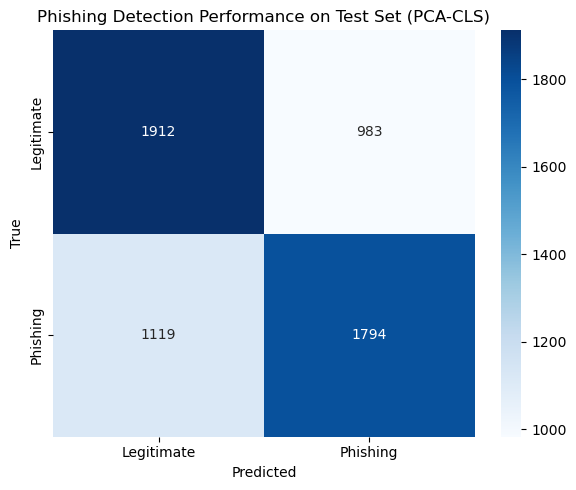

In [28]:
compute_confusion_matrix(y_test, y_preds["pca_cls"], "PCA-CLS")

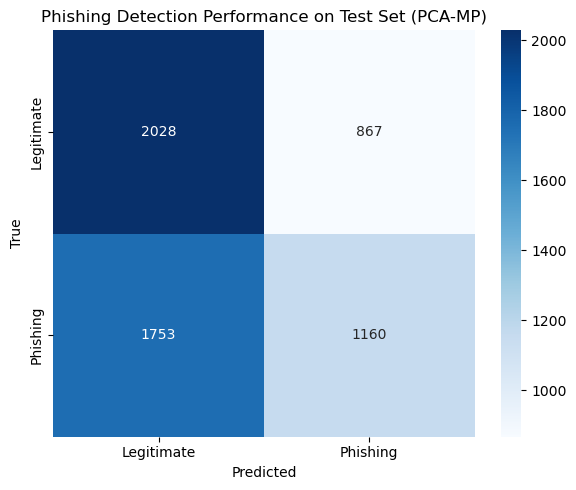

In [22]:
compute_confusion_matrix(y_test, y_preds["pca_mp"], "PCA-MP")

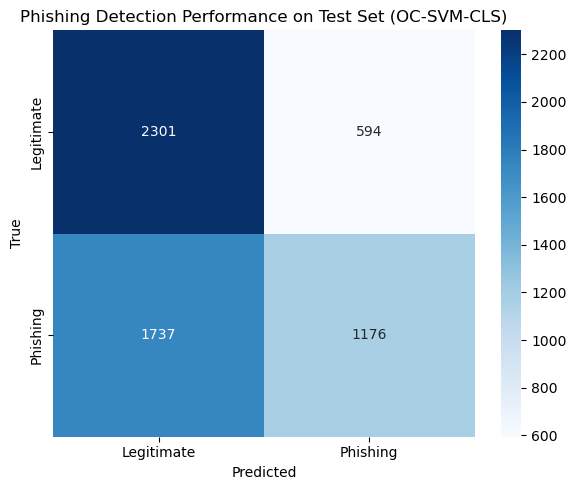

In [23]:
compute_confusion_matrix(y_test, y_preds["ocsvm_cls"], "OC-SVM-CLS")

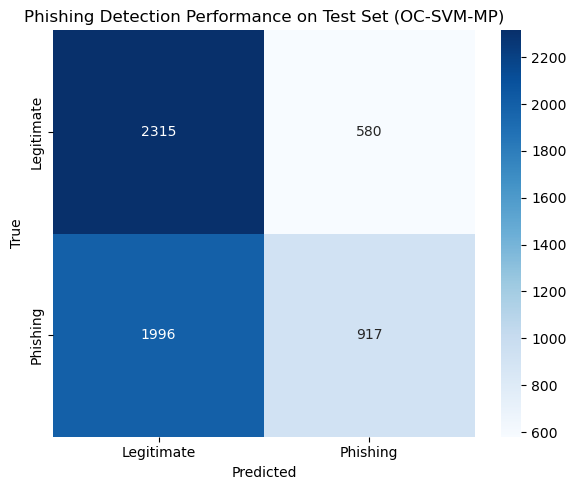

In [24]:
compute_confusion_matrix(y_test, y_preds["ocsvm_mp"], "OC-SVM-MP")

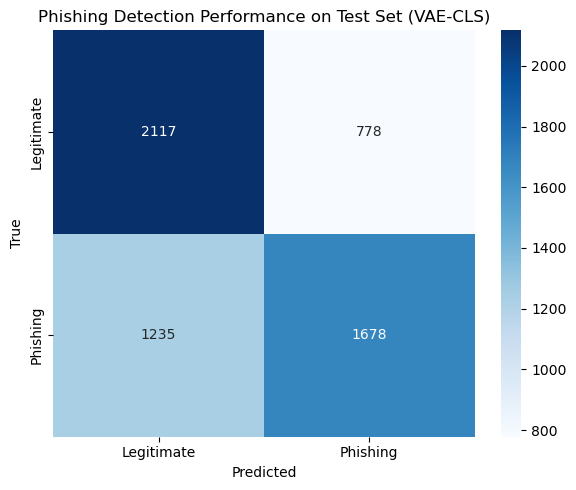

In [25]:
compute_confusion_matrix(y_test, y_preds["vae_cls"], "VAE-CLS")

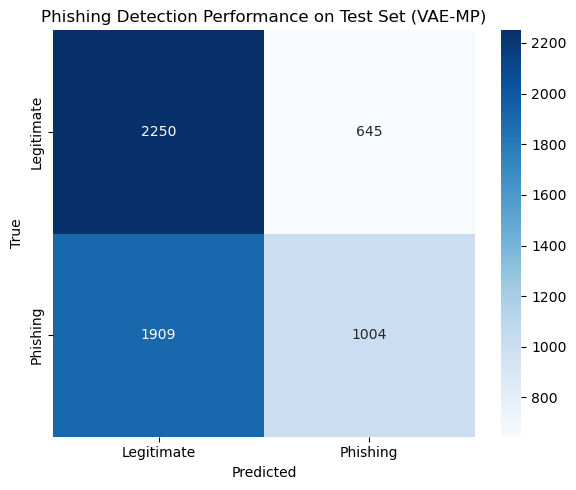

In [26]:
compute_confusion_matrix(y_test, y_preds["vae_mp"], "VAE-MP")

### Wrongly Classified Claims

In [29]:
def is_false_positive(y_true: int, y_pred: int) -> int:
    # Legitimate but classified as phishing
    is_it = (y_true == 0) and (y_pred == 1)
    return int(is_it)

def is_false_negative(y_true: int, y_pred: int) -> int:
    # Phishing but classified as legitimate
    is_it = (y_true == 1) and (y_pred == 0)
    return int(is_it)

def get_false_positives_and_negatives(y_true: pd.Series, y_pred: pd.Series):
    df_results = pd.DataFrame({
        "y_true": y_true,
        "y_pred": y_pred
    }, index=y_true.index)
    df_results["false_positive"] = df_results.apply(
        lambda row: is_false_positive(row["y_true"], row["y_pred"]),
        axis=1
    )
    df_results["false_negative"] = df_results.apply(
        lambda row: is_false_negative(row["y_true"], row["y_pred"]),
        axis=1
    )
    return df_results

In [46]:
model_names = ["pca_cls"]#, "vae_cls"]

for model_name in model_names:
    fp_fn_data = get_false_positives_and_negatives(y_test, y_preds[model_name])
    results = pd.concat([test_emails, fp_fn_data], axis=1)
    
    with pd.ExcelWriter(DATA_FOLDER / "model_result_analysis.xlsx", engine='openpyxl', mode='a') as writer:
        results.to_excel(writer, sheet_name=model_name)